In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.simplefilter("ignore") # Silence warnings

import xarray as xr
import numpy as np
from tqdm import tqdm
import xgcm 
import pop_tools

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cmocean
import cartopy
import cartopy.crs as ccrs
import proplot 
import matplotlib.patches as patches

from utils import *

import datetime as datetime
plt.rcParams['figure.figsize'] = (10.0, 4.0)
plt.rcParams['figure.facecolor'] = 'white'

In [122]:
C=CLSTR(1,45,200,10)

In [121]:
C

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/yeddebba/proxy/46432/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/yeddebba/proxy/46432/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.46:43134,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/yeddebba/proxy/46432/status,Total threads: 0
Started: 46 minutes ago,Total memory: 0 B


In [72]:
di=xr.open_mfdataset('/glade/scratch/yeddebba/Mesoscale/HR/TPAC/final_budget/O2_budget_0005_??.nc', parallel=True,  data_vars="minimal", coords="minimal", compat='override') 
dg0 = xr.open_dataset('/glade/scratch/yeddebba/Mesoscale/HR/TPAC/POP_GRID_F.nc')
di=xr.merge([di,dg0])
varname=['DIV','J_O2','TEND_O2','VDIF','TLAT','TLONG','time','z_t','REGION_MASK','ULAT','ULONG','TAREA']
di=di.drop([v for v in di.variables if v not in varname])
ds=xr.open_mfdataset('/glade/scratch/yeddebba/Mesoscale/HR/TPAC/budgets/STF_O2.0005-??.nc', parallel=True,  data_vars="minimal", coords="minimal", compat='override') 
do=xr.open_mfdataset('/glade/scratch/yeddebba/Mesoscale/HR/TPAC/budgets/AOU.0005-10.nc', parallel=True,  data_vars="minimal", coords="minimal", compat='override').isel(z_t=0) 
dt=xr.open_mfdataset('/glade/scratch/yeddebba/Mesoscale/HR/TPAC/TEMP.0005-??.nc', parallel=True,  data_vars="minimal", coords="minimal", compat='override').isel(z_t=0) 
do2=xr.open_mfdataset('/glade/scratch/yeddebba/Mesoscale/HR/TPAC/O2.0005-??.nc', parallel=True,  data_vars="minimal", coords="minimal", compat='override').isel(z_t=0) 
dsh=xr.open_mfdataset({'/glade/scratch/yeddebba/Mesoscale/HR/TPAC/final_budget/O2_Budget_Mean.nc',})
dl = xr.open_mfdataset('/glade/scratch/yeddebba/Mesoscale/HR/TPAC/OW.000[5]-*.nc', parallel=True, coords="minimal", data_vars="minimal", compat='override')

In [73]:
top=50; bot=150
Si=-2  ; Ni=2 
Ei=-138 ; Wi=-142

N,W=find_indices(dsh.TLONG,dsh.TLAT,360+Wi,Ni)
S,E=find_indices(dsh.TLONG,dsh.TLAT,360+Ei,Si)

# volume integral
dib=(di.isel(nlon=slice(W,E)).sum('nlon').isel(nlat=slice(S,N)).sum('nlat').sel(z_t=slice(top*1e2,bot*1e2)).sum(dim='z_t')*nmol_mol).compute()
dsb=((ds*di.TAREA).isel(nlon=slice(W,E)).sum('nlon').isel(nlat=slice(S,N)).sum('nlat')*nmol_mol).compute()
VOL_shr=(dsh.VOL.isel(nlon=slice(W,E)).sum('nlon').isel(nlat=slice(S,N)).sum('nlat').sel(z_t=slice(top*1e2,bot*1e2)).sum(dim='z_t')*cm3_m3).compute()

In [74]:
O2mt=(do2.O2*mmol_mol*dsh.VOL*cm3_m3).isel(nlon=slice(W,E)).sum('nlon').isel(nlat=slice(S,N)).sum('nlat').sel(z_t=slice(top*1e2,bot*1e2)).sum(dim='z_t').compute()

In [75]:
Si=2  ; Ni=8 
Ei=-138 ; Wi=-142
N,W=find_indices(di.TLONG,di.TLAT,360+Wi,Ni)
S,E=find_indices(di.TLONG,di.TLAT,360+Ei,Si)

OW=dl.OW.isel(nlon=slice(W,E)).mean('nlon').isel(nlat=slice(S,N)).mean('nlat')

In [105]:
def plot_depth_section(ax,x,z, var,cntf,lev,clr,units,title,coords,fs,fsx,lw,alp,cb_on,profile):
    if cntf==True: 
        cs= ax.contourf(x,z,var,levels=lev,cmap=clr,extend='both')
        if cb_on==True:
            cb = plt.colorbar(cs, ax=ax, orientation='vertical', extend='both',pad=0.02)#, aspect=20)  
#             cb.ax.set_title(units,fontsize=fs-1,pad=0.2)
            cb.set_label(units, rotation=0,size=fs-2,position=(0,1.08))
            cb.ax.tick_params(labelsize=fs-1)
            cb.ax.minorticks_off()
    if cntf==False: cs= ax.contour(x,z,var,colors=clr,linewidths=lw,levels=lev,alpha=alp)
    ax.set_title(title,loc='center',fontsize=fs)
    ax.set_ylim(coords[0]); ax.set_xlim(coords[1]); ax.minorticks_on(); 
    ax.set_ylabel('Depth (m)',fontsize=fs-2); 
    ax.set_aspect('auto')
    if profile=='lon': ax.set_xlabel('Latitude ($^{o}$N)',fontsize=fs-2)
    if profile=='lat': ax.set_xlabel('Longitude ($^{o}$E)',fontsize=fs-2)
    ax.set_title(title,pad=0.01,fontsize=fs, loc='center');
    ax.tick_params(axis='both', labelsize=fs)  
    return ax 

def plot_cmap(ax,lon,lat, var,vmn, vmx, stp, clr,units,title,coor,fs,fsx,lon_lab,lat_lab):
    ax.set_extent(coor,crs=cartopy.crs.PlateCarree())
    pc= ax.contourf(lon,lat,var,np.arange(vmn,vmx,stp),cmap=clr,transform=ccrs.PlateCarree(), extend='both') #, 
    land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical', 'land', '10m',linewidth=0.1, edgecolor='black', facecolor='grey'))
    cb = plt.colorbar(pc, ax=ax, orientation='vertical', extend='both',pad=0.02)#, aspect=20)  
    cb.set_label(units, rotation=0,size=fs-3,position=(0.0,1.08))
#     cb.ax.set_title(units,fontsize=fs-1,pad=0.2)
    cb.ax.minorticks_off()
    cb.ax.tick_params(labelsize=fs)
    ax.set_aspect('auto')
    ax.set_title(title,loc='center',fontsize=fs)
    gl=ax.gridlines(draw_labels=True)
    gl.xlabel_style = {'size': fsx, 'color': 'black'}; gl.ylabel_style = {'size': fsx, 'color': 'black'}; 
    gl.xlabels_top = False; gl.ylabels_right= False; gl.xlines = False; gl.ylines = False
    gl.xlocator = mticker.FixedLocator(lon_lab); gl.ylocator = mticker.FixedLocator(lat_lab)
    gl.xformatter = LONGITUDE_FORMATTER ; gl.yformatter = LATITUDE_FORMATTER
    return ax


In [107]:
ds.STF_O2

<xarray.DataArray 'STF_O2' (time: 73, nlat: 631, nlon: 1701)>
dask.array<concatenate, shape=(73, 631, 1701), dtype=float32, chunksize=(7, 631, 1701), chunktype=numpy.ndarray>
Coordinates:
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(631, 1701), meta=np.ndarray>
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(631, 1701), meta=np.ndarray>
  * time     (time) object 0005-01-06 00:00:00 ... 0006-01-01 00:00:00
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Dissolved Oxygen Surface Flux
    units:         mmol/m^3 cm/s
    grid_loc:      2110
    cell_methods:  time: mean

In [117]:
ds['STF_O2']= (ds.STF_O2*di.TAREA)

100%|██████████| 3/3 [03:03<00:00, 61.15s/it] 


<bound method Figure.tight_layout of <Figure size 1600x1400 with 9 Axes>>

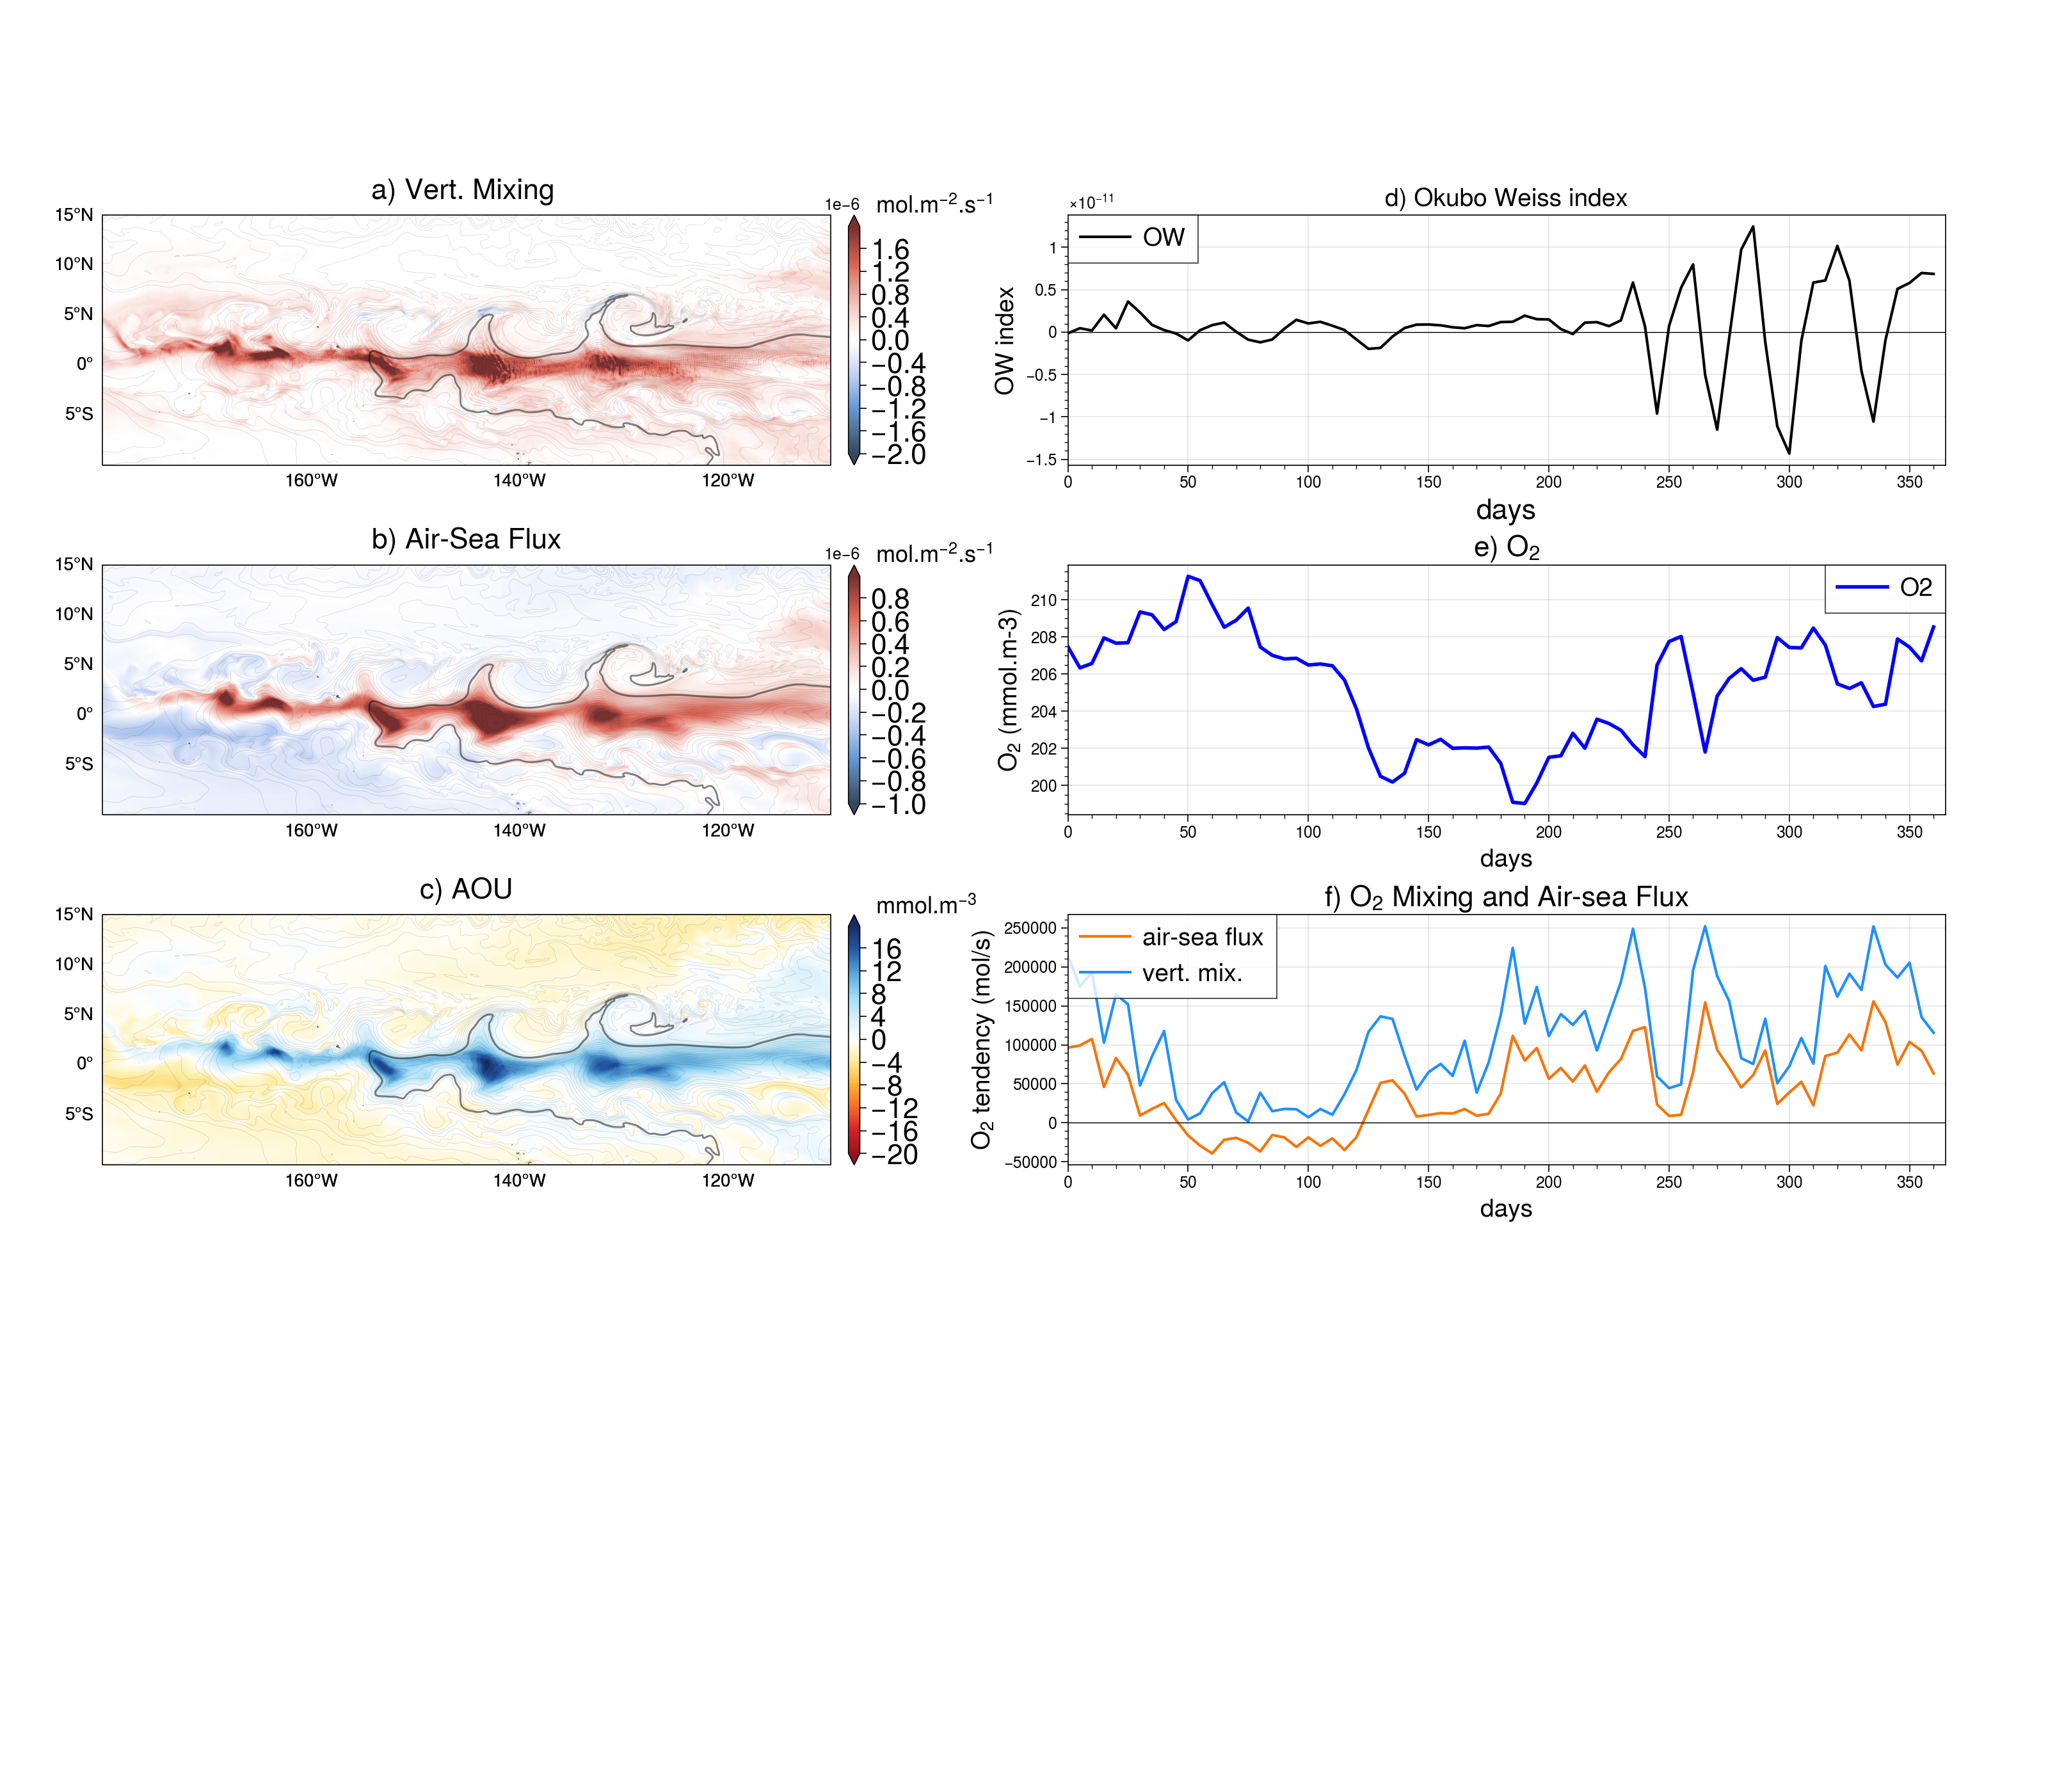

In [145]:
fig = plt.figure(figsize=(16,14),dpi=100)
fs=16; fsx=10
EE=-180.0; WW=-110.1; SS=-10.0; NN=15.1
coor=[EE,WW,SS,NN]; CL=215.0 # central longtiude 
lon_lab=np.concatenate([np.arange(EE,WW,20)])
lat_lab=np.arange(SS,NN,5)

clr_o2='NegPos'
om_clr='blue'
omz_clr='green'
odz_clr='lime'

VAR= [dt.TEMP.where(di.REGION_MASK==2).sel(time='0005-10-03').squeeze(),
      # di.VDIF.sel(time='0005-10-03').sel(z_t=slice(top*1e2,bot*1e2)).sum('z_t').squeeze()*nmol_mol/(dsh.VOL.sel(z_t=slice(top*1e2,bot*1e2)).sum('z_t')*cm3_m3),
      (di.VDIF.sel(time='0005-10-03').sel(z_t=slice(top*1e2,bot*1e2)).sum('z_t').squeeze()*nmol_mol/(dsh.TAREA*cm2_m2)),
      (ds.STF_O2.sel(time='0005-10-03').squeeze()*nmol_mol/(di.TAREA*cm2_m2)),
      do.AOU.sel(time='0005-10-03').squeeze()]

title=['SST','a) Vert. Mixing ', 'b) Air-Sea Flux', 'c) AOU']
units=['$^{o}$ C','mol.m$^{-2}$.s$^{-1}$','mol.m$^{-2}$.s$^{-1}$','mmol.m$^{-3}$']
clrs=['thermal',clr_o2,clr_o2,'ColdHot_r']

lmax=[0.1,2e-6,1e-6,20e0]
lmin=[-0.1,-2e-6,-1e-6,-20e0]
lstp=[0.01,0.1e-7,0.1e-7,20e-2]

gs = fig.add_gridspec(nrows=3, ncols=2, bottom=0.35,left=0.05, right=0.95, wspace=0.1, hspace=0.4)
rng=[0,1,2,3]
r=[0,0,1,2]
c=[0,0,0,0]

for i in tqdm(np.arange(1,4)):#len(VAR))):
    ax = fig.add_subplot(gs[r[i], c[i]] ,projection=ccrs.PlateCarree())
    ax = plot_cmap(ax,dsh.TLONG,dsh.TLAT, VAR[i],lmin[i], lmax[i], lstp[i],
                   clrs[i],units[i],title[i],coor,fs,fsx, lon_lab,lat_lab)
#     ax.contour(dsh.TLONG,dsh.TLAT, dsh.O2.isel(z_t=15),colors=omz_clr,linewidths=0.9,levels=np.arange(60,60.1,5))    
#     ax.contour(dsh.TLONG,dsh.TLAT, dsh.O2.isel(z_t=15),colors=odz_clr,linewidths=0.9,levels=np.arange(20,20.1,5)) 
    ax.contour(di.TLONG, di.TLAT, VAR[0],colors='k', linewidths=1.0, levels=np.arange(25.9,25.95,0.1),alpha=0.5, transform=ccrs.PlateCarree())
    ax.contour(di.TLONG, di.TLAT, VAR[0],colors='k', linewidths=0.2, levels=np.arange(23.0,29.0,0.2),alpha=0.2, transform=ccrs.PlateCarree())
    gl=ax.gridlines(draw_labels=True)
    gl.xlabel_style = {'size': fsx, 'color': 'black'}; gl.ylabel_style = {'size': fsx, 'color': 'black'}; 
    gl.xlabels_top = False; gl.ylabels_right= False; gl.xlines = False; gl.ylines = False
    gl.xlocator = mticker.FixedLocator(lon_lab); gl.ylocator = mticker.FixedLocator(lat_lab)
    gl.xformatter = LONGITUDE_FORMATTER ; gl.yformatter = LATITUDE_FORMATTER

times=np.arange(0,365,5)
ax1 = fig.add_subplot(gs[0:1, 1:2])
ax1.plot(times,OW,label='OW', color='k',lw=1.5)
ax1.set_xlim(0,365)
ax1.axhline(y=0.0, color='k',lw=0.5)
ax1.set_xlabel('days',fontsize=16)
ax1.legend(fontsize=14)
ax1.set_title('d) Okubo Weiss index',fontsize=14)
ax1.set_ylabel('OW index',fontsize=14)

ax1 = fig.add_subplot(gs[1:2, 1:2])

ax1.plot(times,O2mt/mmol_mol/(VOL_shr),
           label='O2', color='blue',lw=2)
ax1.legend(fontsize=14)
ax1.set_title('e) O$_2$',fontsize=16)# integrated over '+str(abs(Wi))+'W-'+str(abs(Ei))+'W '+str(top)+'-'+str(bot)+'m')
ax1.set_ylabel('O$_2$ (mmol.m-3)',fontsize=14)
ax1.set_xlabel('days',fontsize=14)
ax1.set_xlim(0,365)

i=0
ax1 = fig.add_subplot(gs[2:3, 1:2])
ax1.plot(times,dsb.STF_O2,label='air-sea flux', color='orange',lw=1.5)
ax1.plot(times,dib.VDIF,label='vert. mix.', color='dodgerblue',lw=1.5)
ax1.legend(fontsize=14,loc='upper left')
ax1.set_title('f) O$_2$ Mixing and Air-sea Flux',fontsize=16)
ax1.set_ylabel('O$_2$ tendency (mol/s)',fontsize=14)
ax1.axhline(y=0.0, color='k',lw=0.5)
ax1.set_xlabel('days',fontsize=14)
ax1.set_xlim(0,365)

fig.tight_layout
